# Cointegration Analysis of Stock Pairs

This notebook investigates potential cointegration between selected stock pairs using historical price data from `yfinance`. Cointegration refers to a long-term equilibrium relationship between two non-stationary time series, commonly exploited in statistical arbitrage and pair trading strategies.

---

## Methodology

We utilize the **Augmented Dickey-Fuller (ADF) test** to examine the stationarity of the residuals obtained from an OLS regression of one stock on another. If the residuals are stationary, it suggests the existence of a cointegrated relationship.

Mathematically:

For stock prices X_t and Y_t, we fit a model:

$$
Y_t = \alpha + \beta X_t + \epsilon_t
$$

- We then apply the ADF test on the residuals noise, epsilon, to evaluate:

$$
H_0: \text{Residuals are non-stationary} \quad \text{vs} \quad H_1: \text{Residuals are stationary}
$$
---

## Instructions

Please enter two stock tickers below (e.g., `TSLA` and `NVDA`) in the input fields provided. Click **Run Test** to initiate the cointegration analysis.

The results will display the regression parameters, ADF test statistics, and the p-value for statistical significance.

In [132]:
import ipywidgets as widgets
from IPython.display import display, clear_output
tickers = ['AAPL']
tickers_input = widgets.Text(
    value='',
    description='Tickers',
    placeholder='e.g., AAPL, MSFT',
)
add_ticker_button = widgets.Button(description="Add Ticker")
tickers_display = widgets.Text(
    Value ='',
    description='Tickers:',
    disabled = True,
    layout=widgets.Layout(width='30%')
)

def add_ticker(button):
    ticker = tickers_input.value.strip()
    if ticker and ticker not in tickers:
        tickers.append(ticker)
        tickers_input.value = ''
        tickers_display.value = ', '.join(tickers)

add_ticker_button.on_click(add_ticker)
display(tickers_input, add_ticker_button, tickers_display)


Text(value='', description='Tickers', placeholder='e.g., AAPL, MSFT')

Button(description='Add Ticker', style=ButtonStyle())

Text(value='', description='Tickers:', disabled=True, layout=Layout(width='30%'))

C:\Users\tsego\AppData\Local\Temp\ipykernel_4692\1377625413.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period = "3y",)['Close']
[*********************100%***********************]  1 of 1 completed


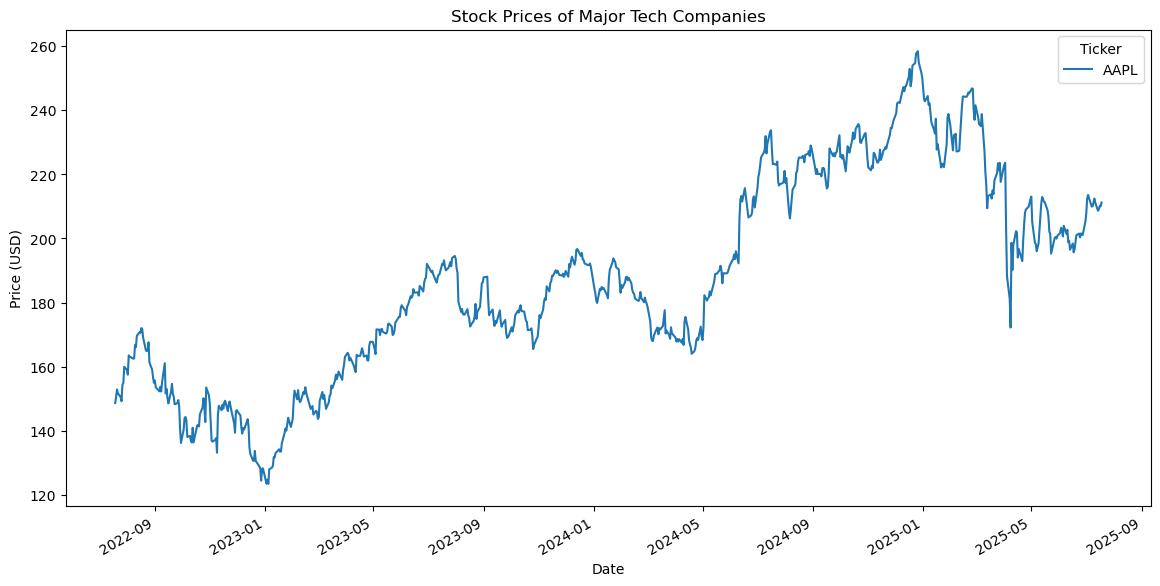

In [133]:
import yfinance as yf
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# We will start out by defining the ticker symbols for the stocks we want to analyze.
# The following code downloads the historical stock prices for a set of major tech companies over the last three years and plots their closing prices.
data = yf.download(tickers, period = "3y",)['Close']
data.plot(figsize=(14, 7))
plt.title('Stock Prices of Major Tech Companies')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

In [134]:
from statsmodels.tsa.stattools import adfuller, coint
import pandas as pd
# Create an empty DataFrame with tickers as both rows and columns
pval_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

# Fill the matrix with p-values from cointegration tests
for i in range(len(tickers)):
    for j in range(len(tickers)):
        if i != j:
            stock1 = data[tickers[i]]
            stock2 = data[tickers[j]]
            _, pval, _ = coint(stock1, stock2)
            pval_matrix.iloc[i, j] = round(pval, 4)  # rounded for readability
        else:
            pval_matrix.iloc[i, j] = None # No self-cointegration

# Display the p-value matrix
display(pval_matrix)

,AAPL
AAPL,NaN


c:\Users\tsego\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\tsego\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


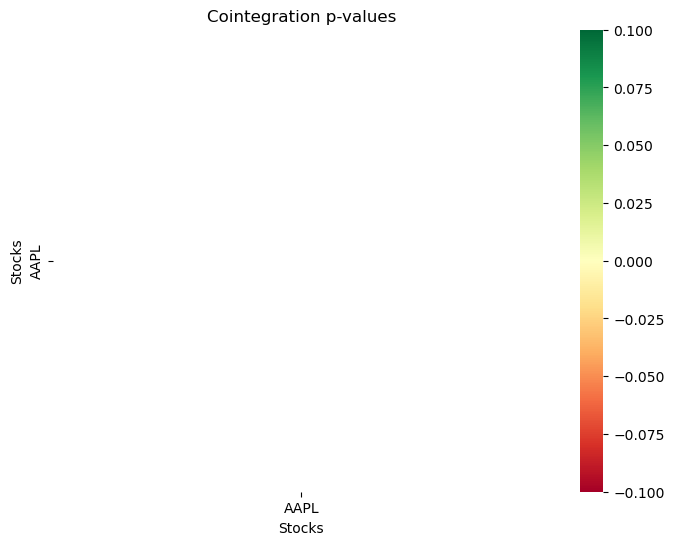

In [135]:
# We can better visualize the cointegration relationships by plotting the the p-value in a heatma.
# The heatmap shows the p-values for the cointegration tests between each pair of stocks.
# A lower p-value indicates a stronger evidence of cointegration.
plt.figure(figsize=(8,6))
sns.heatmap(pval_matrix, annot=True, cmap="RdYlGn", linewidths=.5)
plt.title("Cointegration p-values")
plt.xlabel("Stocks")
plt.ylabel("Stocks")
plt.show()

In [136]:
# After identifying pairs of cointegrated stocks, we can proceed to analyze their spread.
# The spread is the difference between the prices of two cointegrated stocks.
stock1 = widgets.Text(
    value = 'AMZN',
    description = 'Stock 1',
    placeholder = 'eg., AMZN'
)
stock2=widgets.Text(
    value='GOOGL',
    description='stock2',
    placeholder = 'eg., GOOGL'
)
display(stock1, stock2)
# We will now calculate and plot the spread between the two stocks.
def plot_spread(stock1, stock2):
    global z_score
    stock1_data=data[stock1].values.reshape(-1,1)
    stock2_data=data[stock2].values
    model = sm.OLS(stock2_data, stock1_data).fit()
    beta = model.params[0]
    spread=stock2_data - beta * stock1_data.flatten()
    spread_series = pd.Series(spread)
    z_score = (spread_series-spread_series.mean())/spread_series.std()
    pvalue = adfuller(spread)[1]
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, z_score, label='Spread', color='blue')
    plt.axhline(0, color='green', linestyle='--', label='Mean Spread')
    plt.axhline(1.5, color='red', label='Upper Bound (2 Std Dev)', linestyle='--')
    plt.axhline(-1.5, color='red', label='Lower Bound (-2 Std Dev)', linestyle='--')
    plt.title(f'Spread between {stock1} and {stock2}')
    plt.xlabel('Date')
    plt.ylabel(f'Spread with a p-value of {pvalue:.4f}')
show_spread_button = widgets.Button(description="Show Spread")
def on_show_spread_clicked(b):
    plot_spread(stock1.value, stock2.value)
show_spread_button.on_click(on_show_spread_clicked)
display(show_spread_button)


Text(value='AMZN', description='Stock 1', placeholder='eg., AMZN')

Text(value='GOOGL', description='stock2', placeholder='eg., GOOGL')

Button(description='Show Spread', style=ButtonStyle())

In [137]:
# Now that we have the spread, normalized by its mean and standard deviation, we can visualize it.
# For the purpose of this pairs trading strategy, we will use a z-score threshold of 1.5 and -1.5 to determine entry and exit points.
# The strategy is to buy the spread when it is below -1.5 and sell it when it is above 1.5.
def calculate_profit(investment_size):
    global z_score
    global trades
    stock1_prices = data[stock1.value]
    stock2_prices = data[stock2.value]
    z = z_score
    trades = []
    in_position = False
    position_type = None

    for i in range(len(z)):
        price1 = stock1_prices.iloc[i]
        price2 = stock2_prices.iloc[i]
        if not in_position and z[i] < -1.5:
            #Long stock 1 and short stock 2
            stock1_qty = investment_size/2/price1
            stock2_qty = investment_size/2/price2
            entry = {
                'index': i,
                'type': 'long spread',
                'stock1 price': price1,
                'stock2 price': price2,
                'stock1 quantity': stock1_qty,
                'stock2 quantity': stock2_qty,
            }
            in_position = True
            position_type = 'long spread'
        elif not in_position and z[i] > 1.5:
            #Short stock 1 and long stock 2
            stock1_qty = investment_size/2/price1
            stock2_qty = investment_size/2/price2
            entry = {
                'index': i,
                'type': 'short spread',
                'stock1 price': price1,
                'stock2 price': price2,
                'stock1 quantity': stock1_qty,
                'stock2 quantity': stock2_qty
            }
            in_position = True
            position_type = 'short spread'
        elif in_position and abs(z[i])<0.5:
            #Exit position
            entry['exit index'] = i
            entry['exit stock1 price']=price1
            entry['exit stock2 price']=price2
            profit = 0
            if position_type == 'long spread':
                profit = (price2-entry['stock2 price'])*entry['stock2 quantity']+(entry['stock1 price']-price1)*entry['stock1 quantity']
            else:
                profit = (price1-entry['stock1 price'])*entry['stock1 quantity']+(entry['stock2 price']-entry['stock2 price'])*entry['stock2 quantity']
            entry['profit']=profit
            entry['investment size'] = investment_size
            trades.append(entry)
            in_position = False
            position_type = None
            investment_size+= profit
    return trades
investment_size = widgets.FloatText(
    value = 10000,
    description = 'Investment',
    step = 1000,
)
calculate_profit_button = widgets.Button(description="Calculate Profit")
def on_calculate_profit_clicked(b):
    clear_output(wait=True)
    display(investment_size, calculate_profit_button)
    trades = calculate_profit(investment_size.value)
    if trades:
        trades_df = pd.DataFrame(trades)
        display(trades_df)
        total_profit = trades_df['profit'].sum()
        print(f'Total Profit: {total_profit:.2f}')
    else:
        print("No trades executed.")
calculate_profit_button.on_click(on_calculate_profit_clicked)
display(investment_size, calculate_profit_button)
        


FloatText(value=10000.0, description='Investment', step=1000.0)

Button(description='Calculate Profit', style=ButtonStyle())

,index,type,stock1 price,stock2 price,stock1 quantity,stock2 quantity,exit index,exit stock1 price,exit stock2 price,profit,investment size,entry_date,exit_date,duration_days,cumulative_profit
0,206,short spread,$110.26,$116.81,45.347360,42.804754,234,$129.33,$121.61,$864.77,$10000.00,2023-05-12 00:00:00,2023-06-23 00:00:00,42,864.774140
1,301,short spread,$125.98,$131.52,43.121027,41.304257,323,$132.71,$123.72,$290.20,$10864.77,2023-09-28 00:00:00,2023-10-30 00:00:00,32,1154.978793
2,403,long spread,$174.73,$136.75,31.920618,40.786065,440,$179.22,$155.08,$604.29,$11154.98,2024-02-26 00:00:00,2024-04-18 00:00:00,52,1759.265555
3,486,short spread,$186.34,$183.14,31.553252,32.104083,508,$182.50,$166.19,$-121.16,$11759.27,2024-06-25 00:00:00,2024-07-26 00:00:00,31,1638.101185
4,594,long spread,$207.86,$168.53,27.995048,34.528678,621,$222.11,$195.03,$516.11,$11638.10,2024-11-26 00:00:00,2025-01-07 00:00:00,42,2154.215440
5,633,long spread,$235.42,$191.36,25.813898,31.757846,661,$199.25,$173.45,$364.98,$12154.22,2025-01-27 00:00:00,2025-03-07 00:00:00,39,2519.195561
6,675,long spread,$201.36,$162.04,31.086600,38.629039,687,$182.12,$158.88,$475.80,$12519.20,2025-03-27 00:00:00,2025-04-14 00:00:00,18,2994.995878


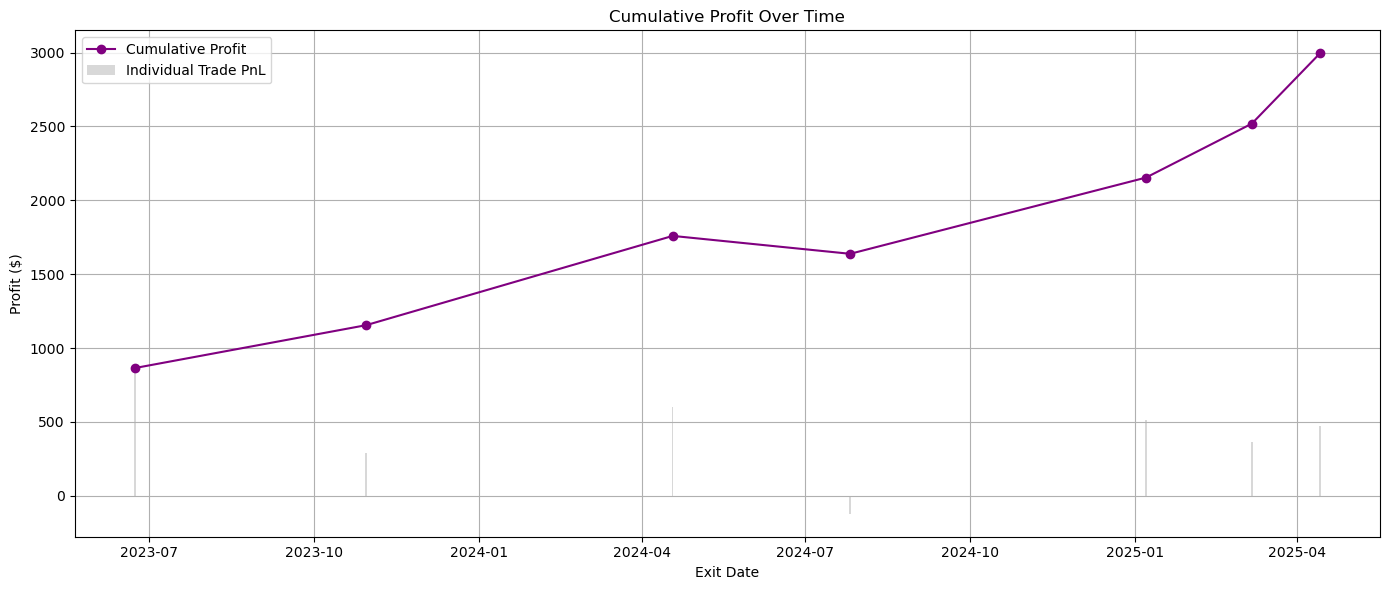

In [138]:
global trades
# Convert list of trades to a DataFrame
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    # Add trade dates and cumulative metrics
    trades_df['entry_date'] = data.index[trades_df['index']]
    trades_df['exit_date'] = data.index[trades_df['exit index']]
    trades_df['duration_days'] = (trades_df['exit_date'] - trades_df['entry_date']).dt.days
    trades_df['cumulative_profit'] = trades_df['profit'].cumsum()

    # 💎 Display styled table
    styled_trades = trades_df.style \
        .format({
            'stock1 price': '${:.2f}',
            'stock2 price': '${:.2f}',
            'exit stock1 price': '${:.2f}',
            'exit stock2 price': '${:.2f}',
            'profit': '${:.2f}',
            'investment size': '${:.2f}'
        }) \
        .highlight_between(subset='profit', left=0, right=trades_df['profit'].max(), color='green')\
        .highlight_between(subset='profit', left=trades_df['profit'].min(), right=0, color='red') \
        .set_caption("📊 Pair Trading Results") \
        .set_table_attributes('style="font-size:12px; width:100%"')

    display(styled_trades)

    # Cumulative profit plot
    plt.figure(figsize=(14, 6))
    plt.plot(trades_df['exit_date'], trades_df['cumulative_profit'], marker='o', linestyle='-', color='purple', label='Cumulative Profit')
    plt.bar(trades_df['exit_date'], trades_df['profit'], color='gray', alpha=0.3, label='Individual Trade PnL')
    plt.title('Cumulative Profit Over Time')
    plt.xlabel('Exit Date')
    plt.ylabel('Profit ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No trade data available to display.")